## Converting segmentation layout to the custom maps of heights

### Examples taken from the CityScapes fine-labelled dataset

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (24.0, 24.0)

In [56]:
default_example = 'vis1.jpg'
cityscapes_example = 'images/5.png'

In [57]:
im_path = cityscapes_example

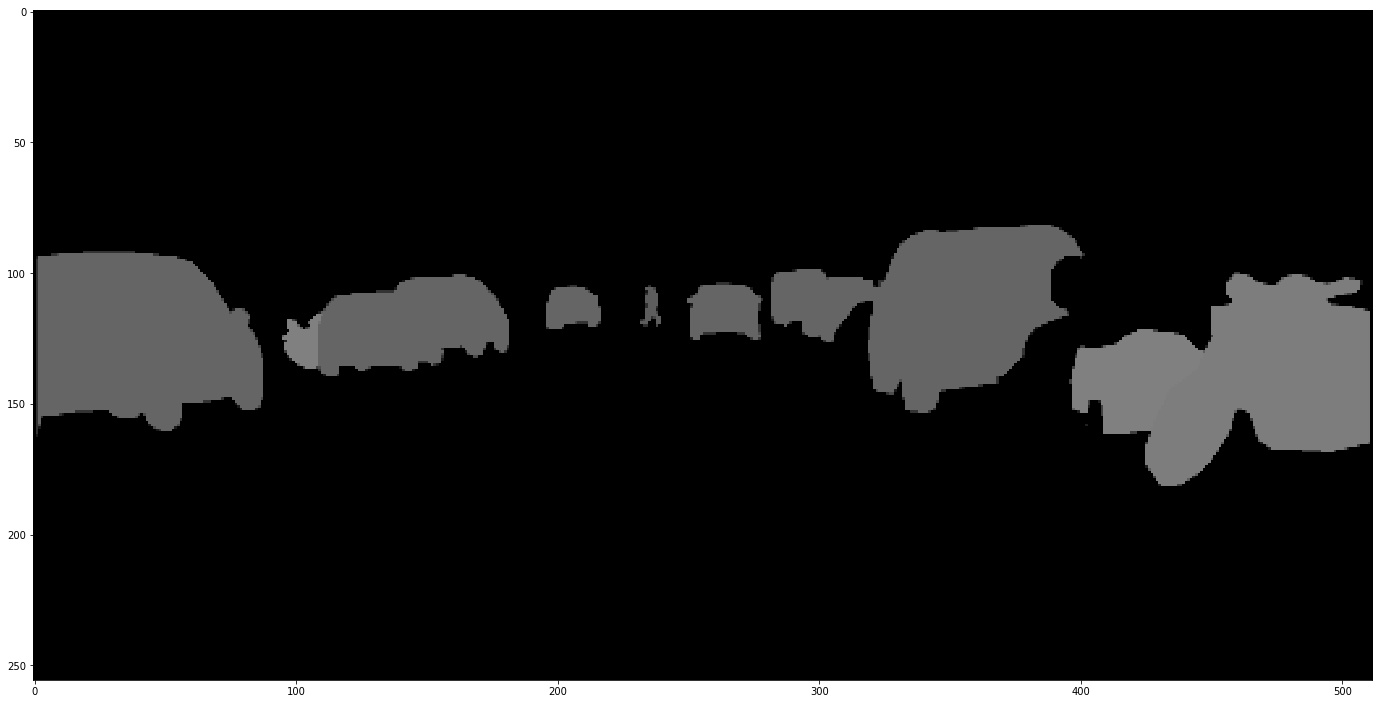

In [58]:
img = cv2.imread(im_path)
img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Set threshold for non-black part (segments). It corresponds to brightness threshold for grayscale (not standartized) and for L2-norm of RGB channels' values.

In [59]:
BACKGROUND_THRESHOLD = 1

In [60]:
def get_horizontal_map(img, mode='gray'):
    # return "map of the heights" for the input image (img)
    # mode switches between grayscale and multichannel mode
    new_img = np.zeros(img.shape[:2])
    for i, row in enumerate(img):
        new_img[i] = coded_row(get_interesting_points(row, mode), len(row))
    return new_img

In [61]:
def get_vertical_map(img, mode='gray'):
    # return "map of the heights" analogically to get_horizontal_map,
    # but vertical (twice uses transponation for it)
    if mode == 'rgb':
        return np.transpose(get_horizontal_map(np.transpose(img,axes=[1,0,2]), mode),axes=[1,0])
    else:
        return np.transpose(get_horizontal_map(np.transpose(img,axes=[1,0]), mode),axes=[1,0])        

In [92]:
def coded_row(interesting_points, length):
    # encodes the row of pixels correspondingly to the interesting points array
    # we don't need to calculate distance for each point, since we know all the
    # transitions (borders)
    if len(interesting_points) == 1:
        return np.zeros((length)) - length//2
        
    background = interesting_points[0]
    #interesting_points.append(length)
    interesting_points.pop(0)
    index = interesting_points[0]
    result = np.zeros((length))
    '''каждому пикселю поставить в соответствие число - 
    расстояние до границы (по вертикали и по горизонтали),
    отрицательные значения - мы на фоне и удаляемся от границы'''
    result[0: interesting_points[0]] = np.zeros((interesting_points[0])) - length//2
    result[interesting_points[-1]: length] = np.zeros((length-interesting_points[-1])) - length//2
    for i in interesting_points:
        
        if (i-index)%2 == 0:
            progression = list(range(0, (i-index)//2))
        else:
            progression = [0] + list(range(0, (i-index)//2))
        if background:
            
            result[index: i - (i-index)//2] = [-x for x in progression]    
            result[index + (i-index)//2: i] = [-x for x in reversed(progression)]
        else:   
            result[index: i - (i-index)//2] = progression
            result[index + (i-index)//2: i] = list(reversed(progression))
        
        background = not background
        index = i
    return result

In [253]:
def get_interesting_points(row, mode='rgb'):
    # encodes the row of raw pixels values into the list of border points
    # can be used in parallel to optimize the performance
    points = []
    if mode == 'rgb':
        nrow = np.apply_along_axis(lambda x: np.linalg.norm(x), 1, row)
    else:
        nrow = row
    
    if np.max(nrow) <= 1.:
        nrow = nrow * 255
    points.append(is_background(nrow[0]))
    for i in range(len(nrow) - 1):
        if is_background(nrow[i]) != is_background(nrow[i + 1]):
            points.append(i)
            
    if not is_background(nrow[-1]):
        points.append(len(nrow))
    return points

In [254]:
def is_background(pixel):
    return pixel <= BACKGROUND_THRESHOLD

In [255]:
def normalize(img):
    lower = np.min(img)
    upper = np.max(img)
    return (img - lower) / (abs(lower) + abs(upper))

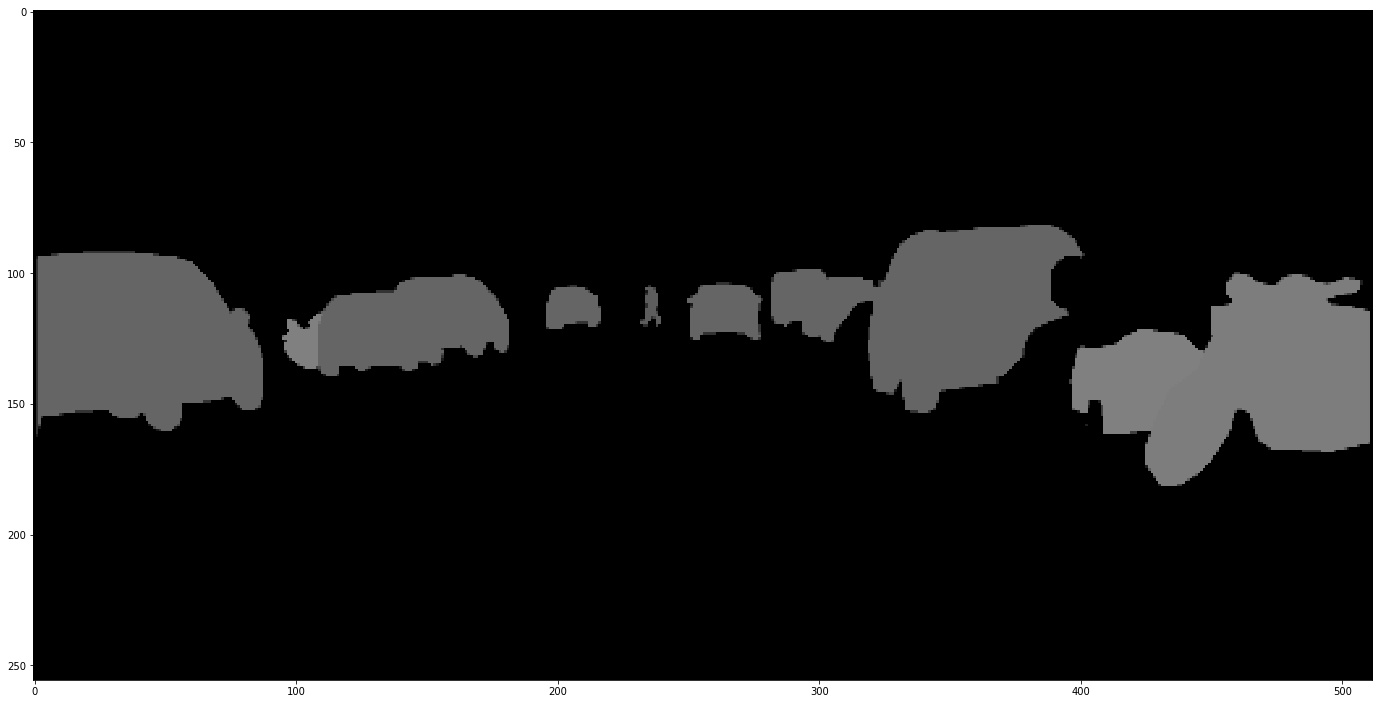

In [256]:
# Feel free to change the number of photo
im_path = 'images/5.png'
img = cv2.imread(im_path)
img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [257]:
hor_map = get_horizontal_map(img, mode = 'rgb')
ver_map = get_vertical_map(img, mode = 'rgb')

hor_map = normalize(hor_map)
ver_map = normalize(ver_map)

In [258]:
# in case you want to apply it to the colour photo and preserve "colour"

# BACKGROUND_THRESHOLD = 122
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# v_channel = hsv[:,:,2]
# hor_map = get_horizontal_map(v_channel)
# ver_map = get_vertical_map(v_channel)
# hsv[:,:,2] = hor_map
# hor_map = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# hsv[:,:,2] = ver_map
# ver_map = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

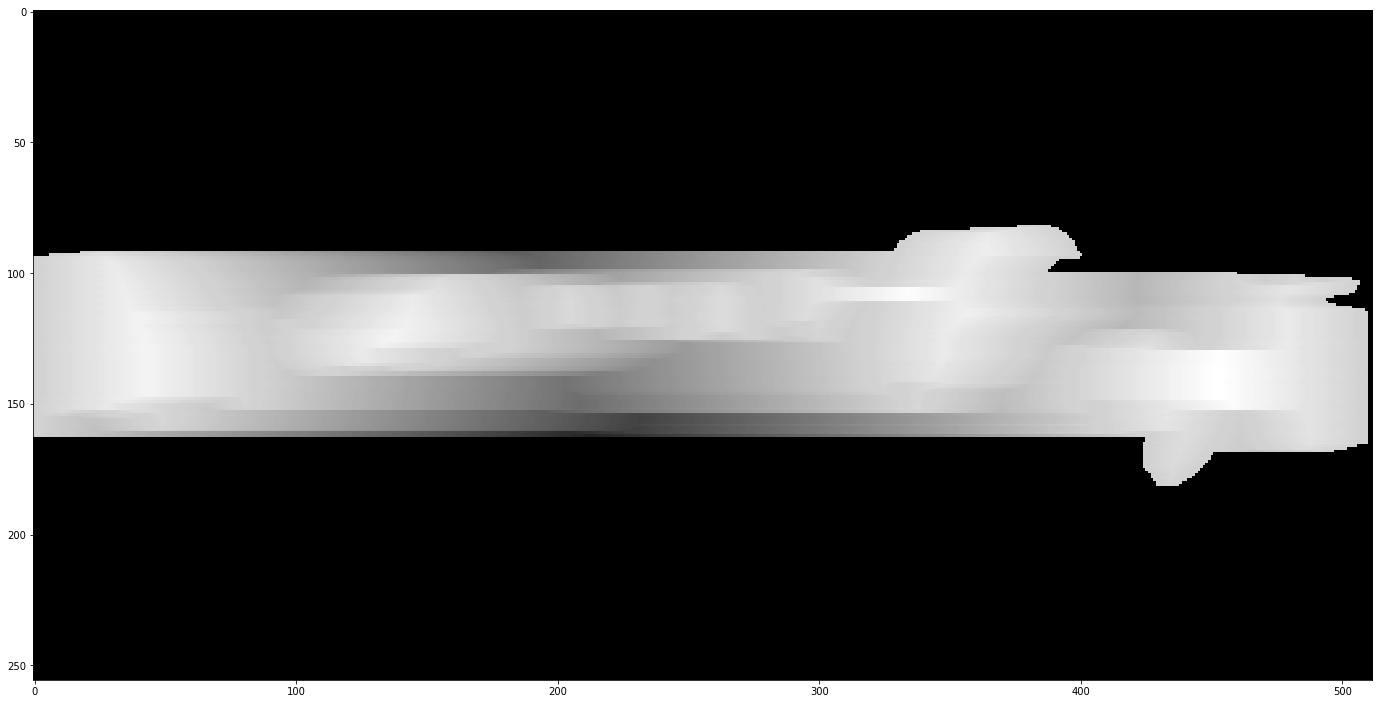

In [259]:
plt.imshow(hor_map, cmap='gray')

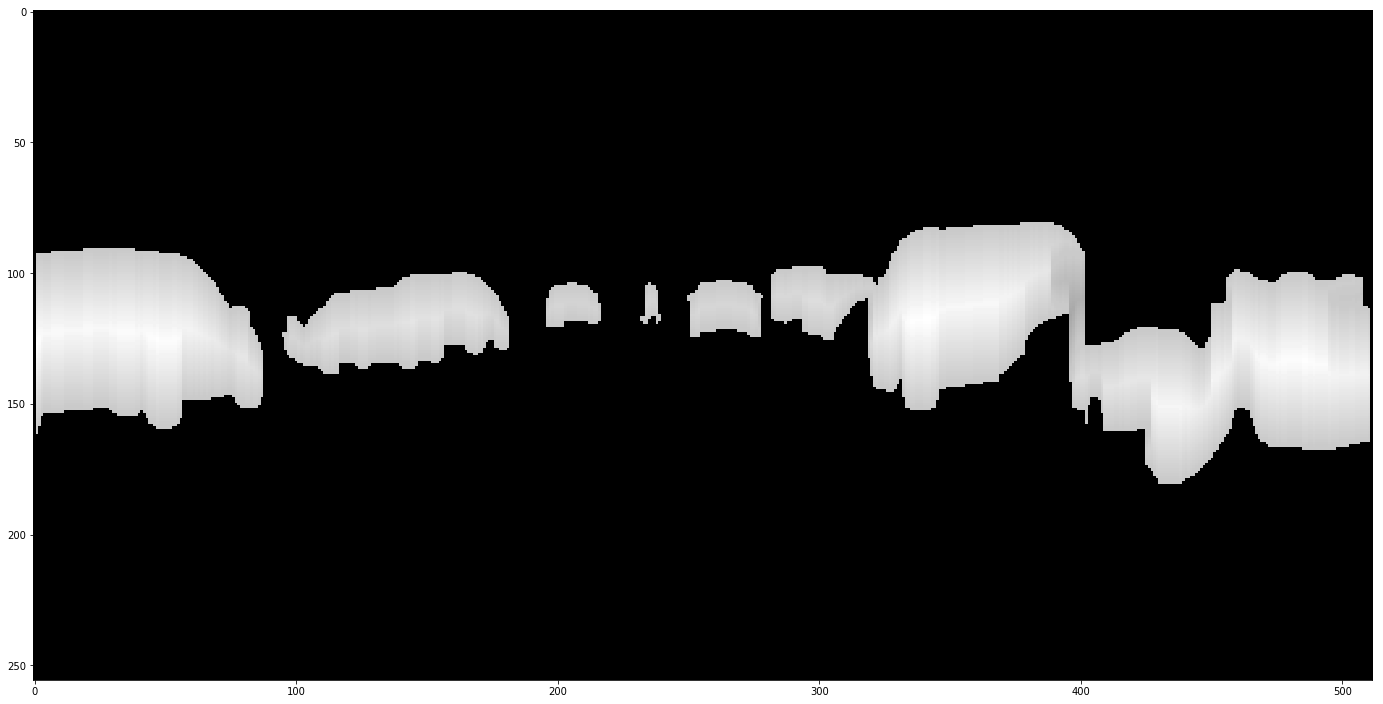

In [260]:
plt.imshow(ver_map, cmap='gray')

In [261]:
def get_contours(img):
    return img==0
    print(mask)
    return cv2.bitwise_and(img,img,mask = mask)

20.0


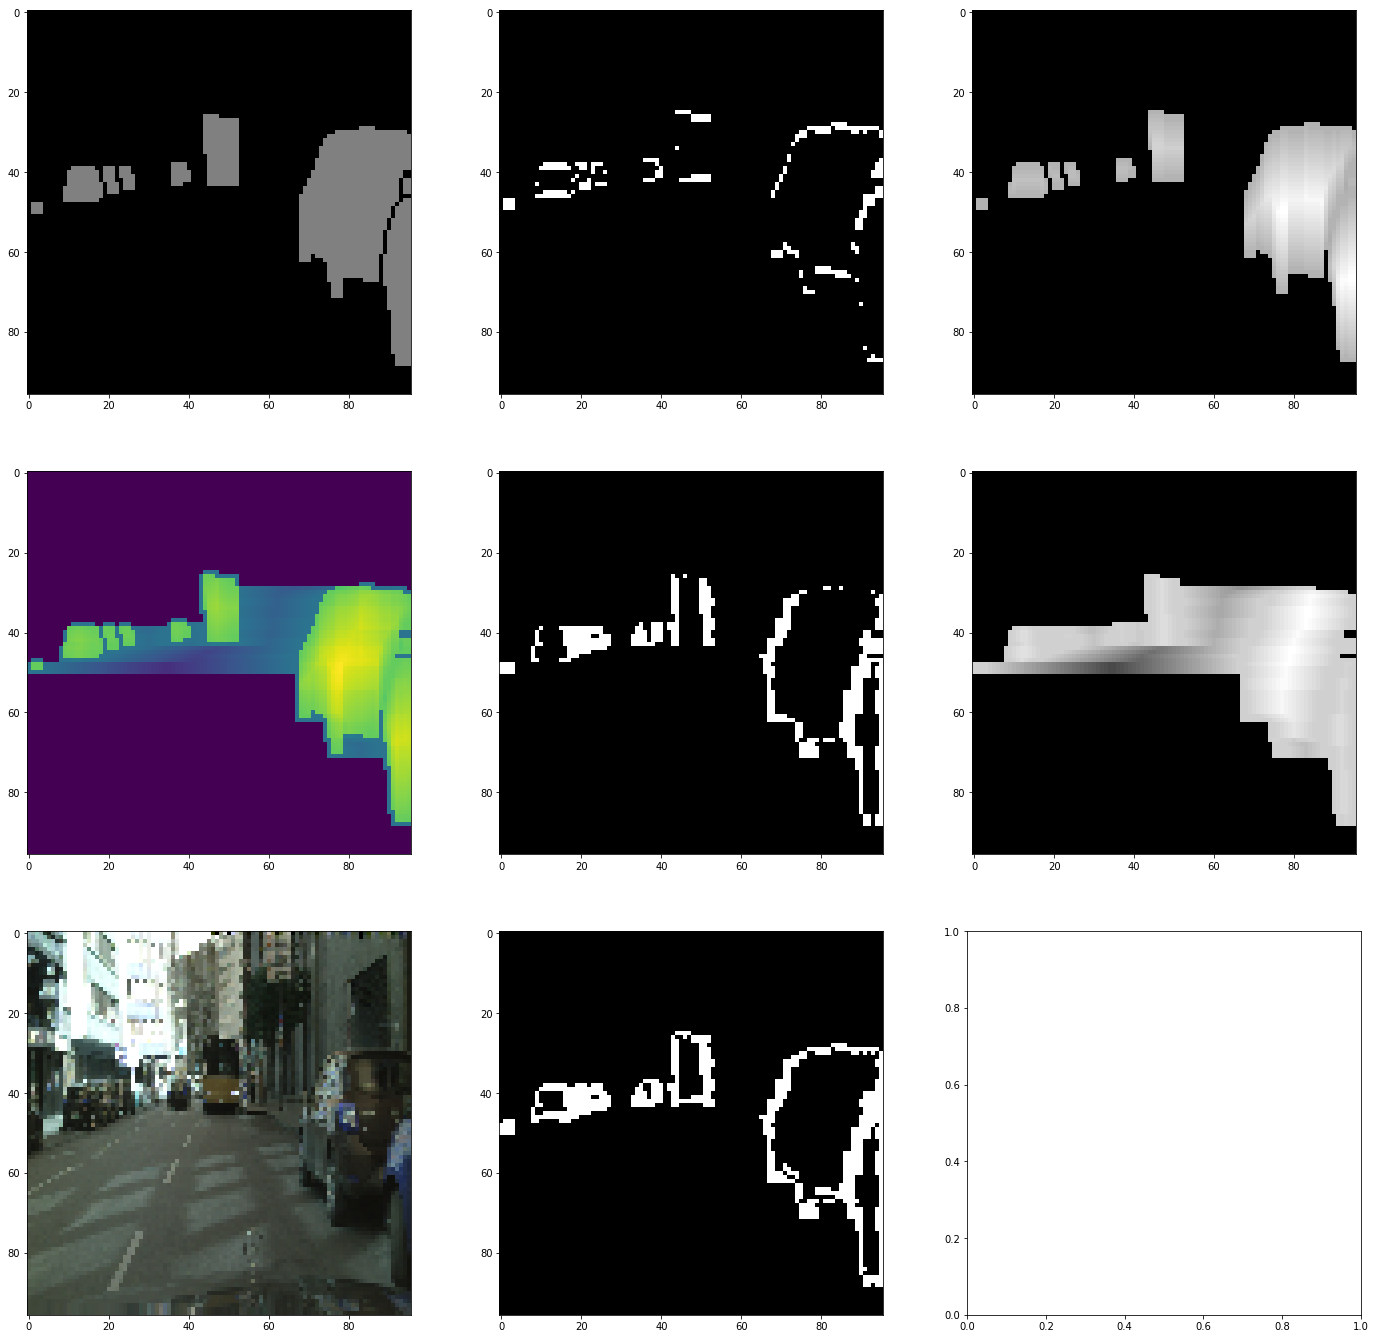

In [267]:
img = cv2.imread(r'data/processed_masks/frankfurt_000000_013382.png')
f, axs = plt.subplots(3, 3)
ax1, ax2, ax3 = axs[0]
ax4, ax5, ax6 = axs[1]
ax7, ax8, ax9 = axs[2]
ax1.imshow(img)
map_ = get_vertical_map(img, mode = 'rgb')
ax2.imshow(get_contours(map_), cmap='gray')
ax3.imshow(map_, cmap='gray')
map_2 = get_horizontal_map(img, mode = 'rgb')
ax5.imshow(get_contours(map_2), cmap='gray')
ax6.imshow(map_2, cmap='gray')
ax4.imshow(map_ + map_2)
simg = cv2.imread(r'data/rbgs/frankfurt_000000_013382_leftImg8bit.png')
simg = cv2.resize(simg, (96, 96), interpolation=1)
ax7.imshow(simg)
ax8.imshow(cv2.bitwise_or(get_contours(map_).astype(np.uint8), get_contours(map_2).astype(np.uint8)), cmap='gray')
print(np.max(map_))

In [195]:
def draw_polygon(points, img, thickness, color):
    cv2.polylines(img,[points],True,color, thickness)

In [196]:
jsons_dir = r'data\jsons'

In [197]:
import os
import json

In [295]:
# target_classes = [
#  'car',
#  'truck',
#  'bus',
#  'train',
#  'motorcycle',
#  'bicycle',
#  'person',
#  'rider'
# ]
target_classes = [
 'car',
]
count = 0
xfactor = 2048 / 96
yfactor = 1024 / 96
kernel = np.ones((3,3),np.uint8)
print(xfactor, yfactor)
for path, subdirs, files in os.walk(jsons_dir):
    for name in files:
        if name.endswith('.json'):
            json_path = os.path.join(path, name)
            json_data = json.loads(open(json_path).read())
            img_path = json_path.replace(r'\jsons' , r'\masks').replace('_polygons.json' , '_instanceIds.png')
            image = cv2.imread(img_path)
            image = cv2.resize(image, (96, 96))
            for frame_object in json_data['objects']:
                label = frame_object['label']
                if label not in target_classes:
                    continue
                points = np.array(frame_object['polygon'])
                points = (points / np.array([xfactor, yfactor])).astype(np.int)
                #print(points)
                #draw_polygon(points, image, 2, (0,255,0))
                cv2.fillPoly(image, [points], color=[128,128,128])
                draw_polygon(points, image, 1, (0,0,0))
            image = cv2.resize(image, (96, 96))
            _,image = cv2.threshold(image,0,128,cv2.THRESH_BINARY)
            image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
#             plt.imshow(image, cmap='gray')
#             raise Exception()
            name = name.split('_gtFine_polygons')[0]
            cv2.imwrite(r'data\processed_masks\{}.png'.format(name), image)
            #raise Exception()

21.333333333333332 10.666666666666666


Exception: 

In [288]:
masks_dir = r'data\processed_masks'
for path, subdirs, files in os.walk(masks_dir):
    for name in files:
        if name.endswith('.png'):
            mask_path = os.path.join(path, name)
            map_path = mask_path.replace(r'\processed_masks' , r'\height_maps')
            mask = cv2.imread(mask_path)
            map1 = get_vertical_map(mask, mode = 'rgb')
            map2 = get_horizontal_map(mask, mode = 'rgb')
            #map maps from 0 to 1
            map1 = map1 / 96. + 0.5
            map2 = map2 / 96. + 0.5
            map1 = map1.reshape(1, 96*96)
            map2 = map2.reshape(1, 96*96)
            map_ = np.hstack([map1, map2]) * 255
#             plt.imshow(map1, cmap='gray')
#             raise Exception()
            cv2.imwrite(map_path, map_)

In [289]:
te=cv2.imread(r'data\height_maps\frankfurt_000000_000294.png')

In [290]:
np.histogram(te)

(array([52287,     0,     0,     0,     0,     0,     0,    39,  2157,
          813], dtype=int64),
 array([  0. ,  15.7,  31.4,  47.1,  62.8,  78.5,  94.2, 109.9, 125.6,
        141.3, 157. ]))

In [296]:
rbgs_dir = r'data\rgbs'
for path, subdirs, files in os.walk(rbgs_dir):
    for name in files:
        if name.endswith('.png'):
            source_path = os.path.join(path, name)
            output_path = source_path.replace(r'\rgbs' , r'\processed_rgbs')
            cv2.imwrite(output_path, cv2.resize(cv2.imread(source_path), (96, 96), interpolation = cv2.INTER_CUBIC))
            #raise Exception()